1. generate time series from no data
    1. just ask model to generate a new time series
    2. just using a traditional GAN
        1. discriminator receives X
        2. generator input is nothing, will make data and input to discriminator
        3. discriminator will tell if it is fake data
        4. once generator tricks the discriminator, the generator model can stand alone as a model to create fake data
   
2. finish a time series from limited data
    1. requires a conditional GAN
    2. input to generator and discriminator has additional input called 'condition'
        1. instead of just having vector, also have condition 'Y'
        2. generator generates realistic fake data, given some condition Y
        3. i.e. Y could be initial time series
        4. discrimintaor also needs the Y condition to discriminate fake btwn known data

3. resolution increasing
    1. also with a conditional GAN
    2. 

In [1]:
import torch
from torch import nn
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

Import Dataframe

In [2]:
df = pd.read_csv('time_data.csv',sep=',')
# df.drop(df[(df['PT08.S1(CO)'] == -200)].index, inplace=True)

In [3]:
df

,time,conv
0,0,0.000000
1,5,3.289106
2,10,6.685466
3,15,9.974572
4,20,12.655909
5,25,14.622222
6,30,17.947079
7,35,20.378158
8,40,22.451725
9,45,23.059494


In [4]:
torch.manual_seed(111)

num = 12

col1 = df['time'].values
col2 = df['conv'].values

array1 = np.zeros(num)
array2 = np.zeros(num)
for i in range(num):
    array1[i] = col1[i]
    array2[i] = col2[i]

train_data_length = num
train_data = torch.zeros((train_data_length, 2))
train_data[:, 0] = torch.from_numpy(array1)
train_data[:, 1] = torch.from_numpy(array2)
train_labels = torch.zeros(train_data_length)
train_set = [(train_data[i], train_labels[i]) for i in range(train_data_length)]

# Define batch size for the data loader
batch_size = 12
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

Discriminator and Generator

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        output = self.model(x)
        return output
    
discriminator = Discriminator()

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
        )

    def forward(self, x):
        output = self.model(x)
        return output

generator = Generator()

In [7]:
# Define learning rate, number of epoch and type of loss function
lr = 0.001
num_epochs = 2000
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [8]:
for epoch in range(num_epochs):

    for n, (real_samples, _) in enumerate(train_loader):

        # Data for training the discriminator

        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))


        # Training the discriminator

        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator

        latent_space_samples = torch.randn((batch_size, 2))


        # Training the generator

        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()


        # Show loss

        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

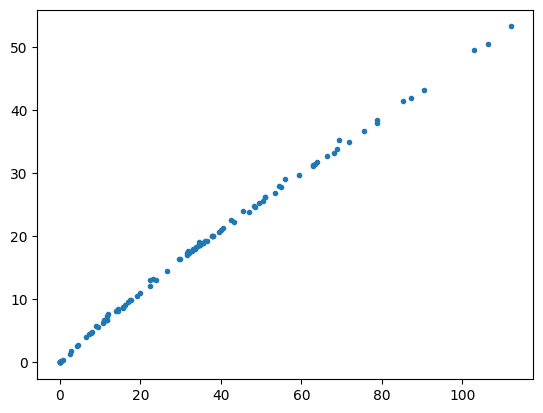

In [9]:
latent_space_samples = torch.randn(100, 2)
generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.detach()
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")

<AxesSubplot: xlabel='time', ylabel='conv'>

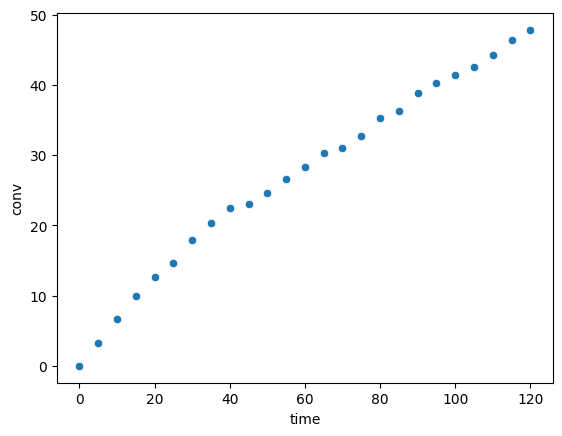

In [10]:
sns.scatterplot(data=df, x='time', y='conv')